# What Happens When Gradient is Zero?

In [3]:
### Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/tmp/ipykernel_3684894/4147228706.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [5]:
def fn(x):
    return torch.sin(5*torch.pi*x)/(5*torch.pi*x)

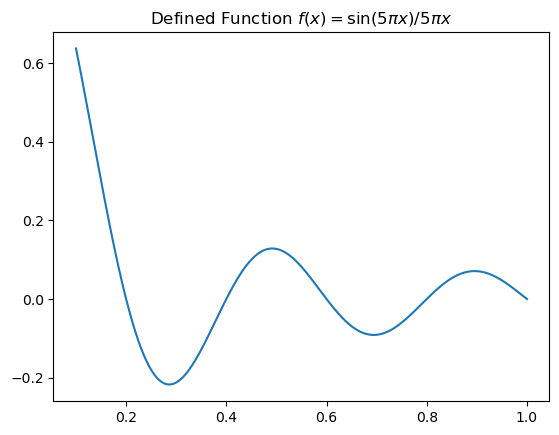

In [6]:
### Plot fn
xvec = torch.linspace(0.1,1,1000)
yvec = fn(xvec)
plt.plot(xvec,yvec, label = "function")
plt.title("Defined Function $f(x)=\sin(5\pi x)/5\pi x$")
plt.show()

In [7]:
class model_class_fn(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=None):
        super(model_class_fn, self).__init__()

        # Store model architecture parameters
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes or []

        # Create layers
        layers = []
        in_features = input_size
        for h_size in hidden_sizes:
            layers.append(nn.Linear(in_features, h_size))
            layers.append(nn.ReLU())  # Add activation after each hidden layer
            in_features = h_size
        layers.append(nn.Linear(in_features, output_size))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        # Forward pass through the layers
        for layer in self.layers:
            x = layer(x)
        return x

In [8]:
def gradient_norm(model):
    grad_all = 0.0
    for p in model.parameters():
        grad = 0.0 
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy() ** 2).sum()
        grad_all += grad

    grad_norm = grad_all ** 0.5
    return grad_norm

In [156]:
### Training function for training on fn(x)
def train_model(model, X_train, Y_train, batch, epochs, learning_rate):

  # send data to device
  X_train, Y_train = X_train.to(device), Y_train.to(device)

  # load training data for model 1
  data_loader = DataLoader(TensorDataset(X_train,Y_train), batch_size=batch, shuffle = True)

  # Create optimizer and loss function
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  loss_fn = nn.MSELoss()
  
  # Send model to device
  model.to(device)

  # Training loop for model 1
  loss_vec = []
  gradient = []

  lossm_val = None
  minimal_ratio = None
  for epoch in range(epochs):
      epoch_loss = 0.0
      for i,data in enumerate(data_loader):
          x_batch, y_batch = data
          optimizer.zero_grad()
      #print(x_train.shape)
          y_pred = model(x_batch)
          loss = loss_fn(y_pred, y_batch)
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
      epoch_loss = epoch_loss/len(data_loader.sampler)
      #if epoch % 10 == 0:
          #print(f"Epoch: {epoch}; loss: {epoch_loss}")
      loss_vec.append(epoch_loss)
      gradient.append(gradient_norm(model))
      total_params=sum(p.numel() for p in model.parameters())
      if (gradient[-1] < 0.001) or (epoch == epochs):
          predicted_y = model(x_batch)
          lossm=loss_fn(predicted_y,y_batch)
          H = torch.zeros((total_params, total_params))

          Jacob = torch.autograd.grad(lossm, list(model.parameters()), create_graph=True)
          Jacob = torch.cat([e.flatten() for e in Jacob]) # flatten
          for i in range(total_params):
            result = torch.autograd.grad(Jacob[i], list(model.parameters()), retain_graph=True)
            H[i] = torch.cat([r.flatten() for r in result]) # flatten
            #H_eig=torch.symeig(H).eigenvalues
            H_eig=torch.linalg.eigvals(H)
            positive_count=0
          for i in H_eig.tolist():
            #print(i)
            if(i.real >0):
                positive_count+=1
          minimal_ratio = positive_count/H.shape[0]
          print('Minimal Ratio - ',minimal_ratio, ' , Loss - ', lossm.data.detach().cpu().numpy(), ' Epoch - ', epoch)
          lossm_val = lossm.data.detach().cpu().numpy()
          break
         
  return lossm_val, minimal_ratio

In [157]:
x_train = torch.linspace(0.1,1,1000).unsqueeze(1)
y_train = fn(x_train)

In [149]:
#model1 = model_class_fn(input_size = 1, output_size = 1, hidden_sizes = [8,8])

In [150]:
#m1_loss, m1_weights = train_model(model1, x_train, y_train, batch = 1000, epochs = 3000, learning_rate=0.001)

In [158]:
loss_arr = []
min_ratio_arr = []
for index in range(100):
    print("Training model ", index)
    model1 = model_class_fn(input_size = 1, output_size = 1, hidden_sizes = [8,8])
    m1_loss, min_ratio = train_model(model1, x_train, y_train, batch = 1000, epochs = 3000, learning_rate=0.001)
    loss_arr.append(m1_loss)
    min_ratio_arr.append(min_ratio)

Training model  0
Minimal Ratio -  0.18556701030927836  , Loss -  0.006455165  Epoch -  1528
Training model  1
Minimal Ratio -  0.17525773195876287  , Loss -  0.006374103  Epoch -  1074
Training model  2
Minimal Ratio -  0.24742268041237114  , Loss -  0.006481807  Epoch -  2141
Training model  3
Minimal Ratio -  0.18556701030927836  , Loss -  0.006406257  Epoch -  2472
Training model  4
Minimal Ratio -  0.15463917525773196  , Loss -  0.022273812  Epoch -  401
Training model  5
Minimal Ratio -  0.15463917525773196  , Loss -  0.006349183  Epoch -  2841
Training model  6
Minimal Ratio -  0.25773195876288657  , Loss -  0.006412824  Epoch -  700
Training model  7
Minimal Ratio -  0.1958762886597938  , Loss -  0.0064850226  Epoch -  1123
Training model  8
Minimal Ratio -  0.24742268041237114  , Loss -  0.020457754  Epoch -  1654
Training model  9
Minimal Ratio -  0.18556701030927836  , Loss -  0.00078478677  Epoch -  1765
Training model  10
Minimal Ratio -  0.18556701030927836  , Loss -  0.0

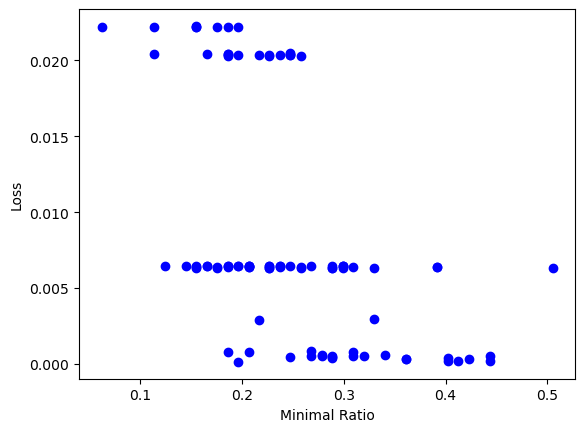

In [162]:
plt.scatter(min_ratio_arr, loss_arr, color = "blue")
plt.xlabel("Minimal Ratio")
plt.ylabel("Loss")
plt.savefig("min_ratio.png")
plt.show()